In [1]:
import json
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm
import pandas as pd

/opt/anaconda/envs/diff-direction/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load the Best Probe Weights

In [41]:
# Path to your results
# MODEL_NAME = "Qwen/Qwen2.5-Math-7B-Instruct"
# MODEL_NAME = "Qwen/Qwen3-4B-Instruct-2507"
MODEL_NAME = "Qwen/Qwen2.5-Math-1.5B-Instruct"
MODEL_ALIAS = "Qwen-Qwen2.5-Math-1.5B-Instruct"
# MODEL_ALIAS = MODEL_NAME.split("/")[-1]
RESULTS_DIR = f"../probe_results/DATA/SR_DATA/MATH/{MODEL_ALIAS}_maxlen_3000_k_1_temp_0.0"

# Load best probe data
with open(f"{RESULTS_DIR}/best_probe_predictions.json", 'r') as f:
    best_probe = json.load(f)

probe_weights = np.array(best_probe['probe_weights'])  # [D] dimension vector
best_layer = best_probe['best_layer']
best_position = best_probe['best_position']
cv_score = best_probe['cv_score']
test_score = best_probe['test_score']

print(f"Best probe: Layer {best_layer}, Position {best_position}")
print(f"CV Score: {cv_score:.4f}, Test Score: {test_score:.4f}")
print(f"Probe weights shape: {probe_weights.shape}")

Best probe: Layer 18, Position -1
CV Score: 0.8793, Test Score: 0.8516
Probe weights shape: (1536,)


## 2. Load Model and Extract Embedding Matrix

In [42]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
vocab_size = len(tokenizer)
print(f"Vocabulary size: {vocab_size}")

# Load model to get embeddings
print("Loading model (this may take a moment)...")
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16,
    device_map="cpu",  # Keep on CPU for analysis
)

# Get embedding matrix
embedding_matrix = model.get_input_embeddings().weight.data.cpu().float().numpy()  # [vocab_size, d_model]
print(f"Embedding matrix shape: {embedding_matrix.shape}")

Vocabulary size: 151665
Loading model (this may take a moment)...
Embedding matrix shape: (151936, 1536)
Embedding matrix shape: (151936, 1536)


## 3. Compute Dot Products with All Tokens

In [43]:
# Compute dot product: embedding_matrix @ probe_weights
# This tells us how much each token "activates" the probe direction
dot_products = embedding_matrix @ probe_weights  # [vocab_size]

print(f"Dot products shape: {dot_products.shape}")
print(f"Min: {dot_products.min():.4f}, Max: {dot_products.max():.4f}, Mean: {dot_products.mean():.4f}")

Dot products shape: (151936,)
Min: -0.0419, Max: 0.0485, Mean: 0.0038


## 4. Find Top Tokens (Highest Activations)

In [44]:
# Get top K tokens with highest dot products
TOP_K = 50

top_indices = np.argsort(dot_products)[-TOP_K:][::-1]  # Descending order
top_scores = dot_products[top_indices]
top_tokens = [tokenizer.decode([idx]) for idx in top_indices]

# Create DataFrame
top_df = pd.DataFrame({
    'rank': range(1, TOP_K + 1),
    'token_id': top_indices,
    'token': top_tokens,
    'dot_product': top_scores,
})

print(f"\n{'='*60}")
print(f"TOP {TOP_K} TOKENS (Highest Activation)")
print(f"{'='*60}\n")
print(top_df.to_string(index=False))


TOP 50 TOKENS (Highest Activation)

 rank  token_id         token  dot_product
    1     15442      evaluate     0.048518
    2     37563    evaluating     0.046514
    3     60969      umerator     0.046244
    4     82345      Evaluate     0.045059
    5     67427       fencing     0.044881
    6      3947         visit     0.043775
    7    110640            最少     0.043580
    8      1056          line     0.043274
    9     48924    successive     0.042615
   10     67279             包     0.042548
   11     20408        ometer     0.042030
   12     55081   evaluations     0.041189
   13     92984    Arithmetic     0.041076
   14     21206         stamp     0.041046
   15     10191      coverage     0.040794
   16     54115      Evaluate     0.040721
   17     63275            BX     0.040524
   18      6077        sample     0.040484
   19      3122           unk     0.040159
   20     18052          mate     0.039506
   21     14581            &=     0.039231
   22    105470  

## 5. Find Bottom Tokens (Lowest Activations)

In [48]:
# Get bottom K tokens (most negative)
bottom_indices = np.argsort(dot_products)[:TOP_K]
bottom_scores = dot_products[bottom_indices]
bottom_tokens = [tokenizer.decode([idx]) for idx in bottom_indices]

bottom_df = pd.DataFrame({
    'rank': range(1, TOP_K + 1),
    'token_id': bottom_indices,
    'token': bottom_tokens,
    'dot_product': bottom_scores,
})

print(f"\n{'='*60}")
print(f"BOTTOM {TOP_K} TOKENS (Lowest Activation)")
print(f"{'='*60}\n")
print(bottom_df.to_string(index=False))


BOTTOM 50 TOKENS (Lowest Activation)

 rank  token_id        token  dot_product
    1     10277     properly    -0.041907
    2    101147           方便    -0.041532
    3      9210        angle    -0.038870
    4      4586      general    -0.037919
    5      8661       easier    -0.037523
    6     19703        roots    -0.037082
    7     12128       closer    -0.036741
    8     54039            州    -0.035997
    9       220                 -0.035497
   10      6169       proper    -0.035497
   11      2266      context    -0.034875
   12      1736         post    -0.034571
   13     59008       slopes    -0.034186
   14     12264      trouble    -0.034097
   15      1070          ute    -0.033958
   16      2421          few    -0.033532
   17      2251         ency    -0.033384
   18    101121           范围    -0.033177
   19     16129   tournament    -0.033031
   20     89549       -plane    -0.032924
   21     25941       angles    -0.032869
   22      5523           /t    -0.03

## 6. Visualize Distribution

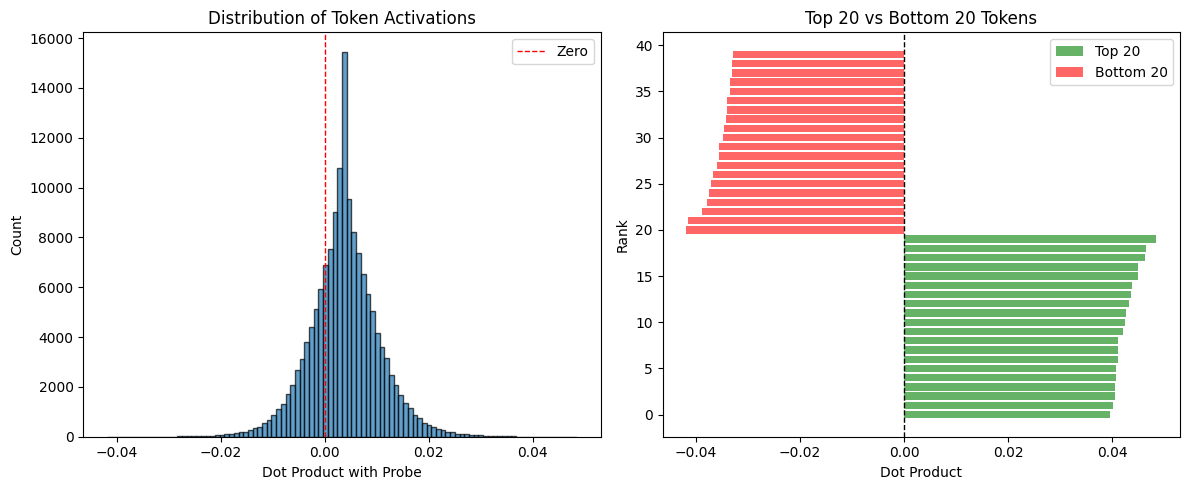

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(dot_products, bins=100, edgecolor='black', alpha=0.7)
plt.xlabel('Dot Product with Probe')
plt.ylabel('Count')
plt.title('Distribution of Token Activations')
plt.axvline(0, color='red', linestyle='--', linewidth=1, label='Zero')
plt.legend()

# Top/Bottom bars
plt.subplot(1, 2, 2)
plt.barh(range(20), top_scores[:20][::-1], color='green', alpha=0.6, label='Top 20')
plt.barh(range(20, 40), bottom_scores[:20], color='red', alpha=0.6, label='Bottom 20')
plt.xlabel('Dot Product')
plt.ylabel('Rank')
plt.title('Top 20 vs Bottom 20 Tokens')
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.legend()

plt.tight_layout()
plt.show()

## 7. Save Results

In [47]:
# Save to CSV
top_df.to_csv(f"{RESULTS_DIR}/top_tokens.csv", index=False)
bottom_df.to_csv(f"{RESULTS_DIR}/bottom_tokens.csv", index=False)

print(f"\nResults saved to:")
print(f"  - {RESULTS_DIR}/top_tokens.csv")
print(f"  - {RESULTS_DIR}/bottom_tokens.csv")


Results saved to:
  - ../probe_results/DATA/SR_DATA/MATH/Qwen-Qwen2.5-Math-1.5B-Instruct_maxlen_3000_k_1_temp_0.0/top_tokens.csv
  - ../probe_results/DATA/SR_DATA/MATH/Qwen-Qwen2.5-Math-1.5B-Instruct_maxlen_3000_k_1_temp_0.0/bottom_tokens.csv


## 8. Interpretation

- **High dot product tokens**: These tokens, when they appear at the probe's position/layer, strongly activate in the direction the probe learned to associate with high success rate.
- **Low dot product tokens**: These tokens activate in the opposite direction

**Note**: This analysis uses the embedding matrix, so it shows tokens at the input level. The actual activations the probe sees are after being processed through layers of the transformer, so this is an approximation of what the probe detects.